1: Environment Setup & Dependencies

In [3]:
%pip install seaborn
import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display

# Import project-specific config
import sys
sys.path.append("..")
from config.global_config import GlobalConfig

# Set visualization style
plt.style.use('ggplot')
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


2: Recursive Data Scanning

In [4]:
def scan_dicom_directory(root_dir):
    dicom_records = []
    root_path = Path(root_dir)
    
    # Using stop_before_pixels=True makes scanning 100x faster
    all_files = list(root_path.glob("**/*.dcm"))
    print(f"🔍 Found {len(all_files)} DICOM files. Extracting metadata...")

    for fpath in tqdm(all_files):
        try:
            ds = pydicom.dcmread(fpath, stop_before_pixels=True)
            dicom_records.append({
                "patient_id": ds.get("PatientID", "Unknown"),
                "modality": ds.get("Modality", "Unknown"),
                "body_part": ds.get("BodyPartExamined", "Unknown"),
                "pixel_spacing": str(ds.get("PixelSpacing", "N/A")),
                "slice_thickness": ds.get("SliceThickness", "N/A"),
                "manufacturer": ds.get("Manufacturer", "Unknown"),
                "rows": ds.get("Rows", 0),
                "cols": ds.get("Columns", 0),
                "file_path": str(fpath)
            })
        except Exception as e:
            print(f"⚠️ Error reading {fpath}: {e}")
            
    return pd.DataFrame(dicom_records)

df_raw = scan_dicom_directory(GlobalConfig.RAW_DATA_DIR)
display(df_raw.head())

🔍 Found 0 DICOM files. Extracting metadata...


0it [00:00, ?it/s]


""


3: Spatial & Clinical Data Profiling

ValueError: Could not interpret value `modality` for `x`. An entry with this name does not appear in `data`.

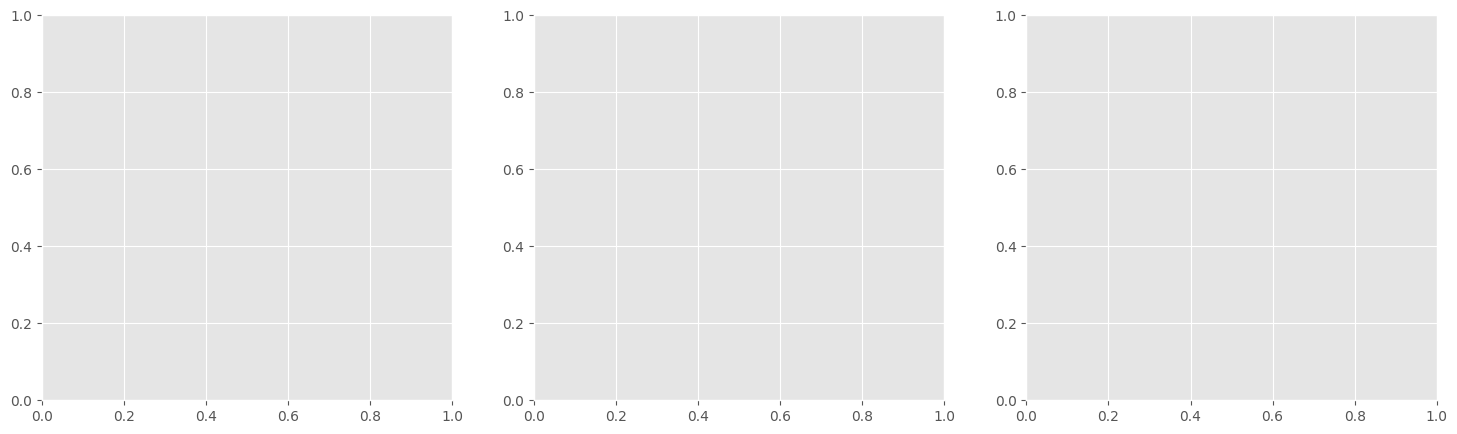

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Modality Distribution
sns.countplot(data=df_raw, x='modality', ax=axes[0])
axes[0].set_title("Modality Consistency")

# 2. Scanner Manufacturer (Key for checking bias)
sns.countplot(data=df_raw, x='manufacturer', ax=axes[1])
axes[1].set_title("Hardware Distribution")

# 3. Slice Thickness Analysis
df_raw['slice_thickness'] = pd.to_numeric(df_raw['slice_thickness'], errors='coerce')
sns.histplot(df_raw['slice_thickness'].dropna(), kde=True, ax=axes[2])
axes[2].set_title("Slice Thickness Variation (mm)")

plt.tight_layout()
plt.show()

4: Hounsfield Unit (HU) Intensity Analysis

In [ ]:
def get_hu_distribution(file_path):
    ds = pydicom.dcmread(file_path)
    image = ds.pixel_array.astype(np.float32)
    
    # Convert to Hounsfield Units (HU)
    intercept = ds.RescaleIntercept if 'RescaleIntercept' in ds else 0
    slope = ds.RescaleSlope if 'RescaleSlope' in ds else 1
    hu_image = slope * image + intercept
    
    return hu_image.flatten()

# Sample a random patient
sample_path = df_raw.sample(1)['file_path'].values[0]
hu_values = get_hu_distribution(sample_path)

plt.figure(figsize=(10, 4))
sns.histplot(hu_values, bins=100, color='teal')
plt.axvline(-1000, color='red', linestyle='--', label='Air')
plt.axvline(0, color='blue', linestyle='--', label='Water')
plt.axvline(400, color='orange', linestyle='--', label='Bone')
plt.title("Intensity Profile (Hounsfield Units)")
plt.legend()
plt.show()

5: Interactive Clinical Slice Viewer

def visualize_scan(patient_id):
    patient_files = df_raw[df_raw['patient_id'] == patient_id]['file_path'].tolist()
    # Sort files by Instance Number/Location to ensure spatial order
    slices = [pydicom.dcmread(f) for f in patient_files]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    
    vol = np.stack([s.pixel_array for s in slices])

    def scroll_slices(index):
        plt.figure(figsize=(6, 6))
        # Apply standard soft-tissue windowing (Level 40, Width 400)
        plt.imshow(vol[index], cmap='gray', vmin=-160, vmax=240)
        plt.title(f"Patient: {patient_id} | Slice: {index}")
        plt.axis('off')
        plt.show()

    widgets.interact(scroll_slices, index=widgets.IntSlider(min=0, max=len(vol)-1, step=1, value=0))

# Trigger viewer for first patient in list
visualize_scan(df_raw['patient_id'].unique()[0])

6: Export Clean Manifest (The Data Contract)

# Filtering criteria: Remove modality 'SC' (Secondary Capture/Screenshots)
df_clean = df_raw[df_raw['modality'] != 'SC'].copy()

# Add a unique internal ID
df_clean['internal_id'] = "MED_" + df_clean['patient_id']

# Save to Metadata directory
output_path = GlobalConfig.METADATA_DIR / "dataset_manifest.csv"
df_clean.to_csv(output_path, index=False)

print(f"✅ EDA Complete. Manifest saved with {len(df_clean['patient_id'].unique())} unique patients.")